# Taxi Prospection
Prediction of the amount of next hour taxi orders with a small deviation (RMSE)

## Data Overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=True).sort_values(by=['num_orders']) # Importing the data as Datetime

In [3]:
# Look into the data
df.sample(5)

,num_orders
datetime,
2018-03-30 02:50:00,10
2018-04-30 06:40:00,7
2018-07-08 03:20:00,26
2018-04-04 21:10:00,14
2018-06-28 12:10:00,20


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-04-29 06:30:00 to 2018-08-27 02:10:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


> 1 column of the number of taxi orders. the data is for the period 1.3.2018 - 31.8.2018, with 26,496 rows.

In [5]:
#makong the data for 1 hour groups - we need to find the amount for next hour, while the data is splitted for 10 minutes
df = df.resample('1H').sum() 

In [6]:
#data distribution parameters
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


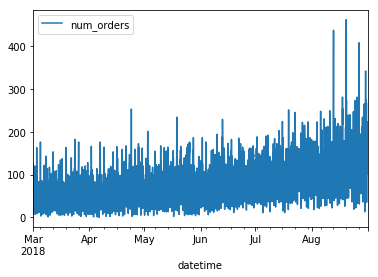

In [24]:
df.plot() #general distribution

> there is some trend maybe but it's to messy. need to clear up.

In [8]:
# Time usually has seasonal patterns/trends
decomposed = seasonal_decompose(df)

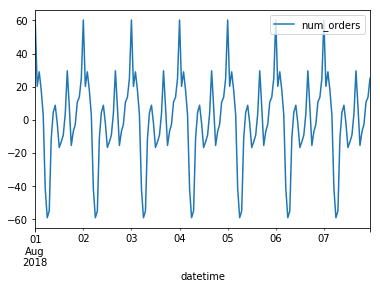

In [9]:
decomposed.seasonal['2018-08-01':'2018-08-07'].plot() #looking for a daily pattern (I picked a random week)

> There is clearly a daily pattern

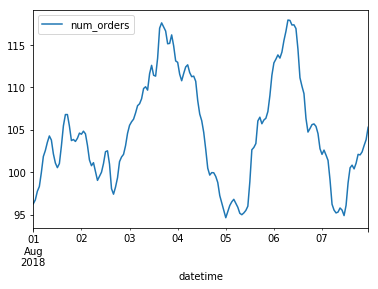

In [10]:
decomposed.trend['2018-08-01':'2018-08-07'].plot() #looking for a weekly trend

> There is also some trend, most likely weekdays-weekend

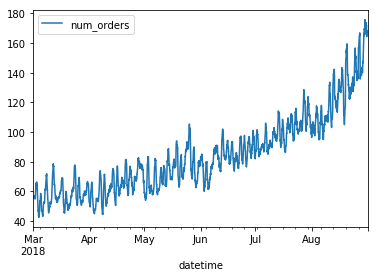

In [11]:
decomposed.trend.plot() #general trend?

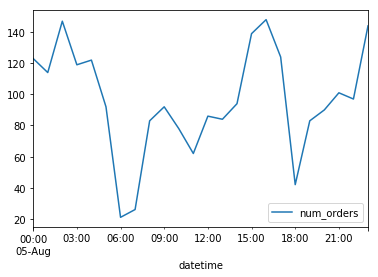

In [12]:
df['2018-08-05'].plot() #just checking my birthday :)

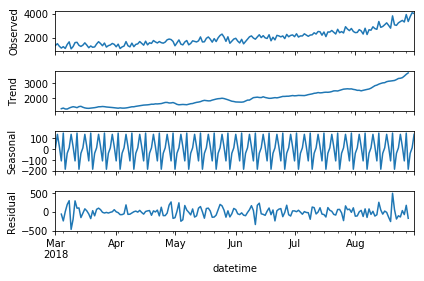

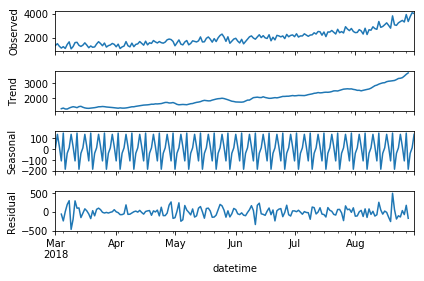

In [13]:
seasonal_decompose(df.resample('1D').sum()).plot() #looking for daily patterns

> There is a daily pattern but also changes over time.

## Data Preprocessing

In [14]:
# Splitting the date-time feature to different features for the model prediction.
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month #for month influence
    data['day'] = data.index.day #for day of the month influence
    data['dayofweek'] = data.index.dayofweek #for day of the week influence
    
    for lag in range(1, max_lag + 1): #making features based on the past - when predicting next hour we use last hour behavior
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    #for better prediction we use the mean, to avoid influence of extrime values.
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() 

data = df.copy()

#Max lag is 24, because we expect a daily repetition (and olso 7 is included for weekly). for rolling 3 should be enough.
make_features(data, 24, 3)
data.dropna(inplace=True) #dropping missing values from shifting

In [15]:
#splitting the data to train set and test set.
features = data.drop('num_orders', axis=1)
target = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, shuffle=False, random_state=42)

## Modeling

In [16]:
results = [['model','RMSE', 'R2']] #A table with all the results for comparing them later

def adding_results(model, model_name): #adding a new row with RMSE and r-squared to the results table
    predictions=model.predict(X_test)
    result = [model_name, mean_squared_error(y_test, predictions)**0.5,  r2_score(y_test, predictions)]
    results.append(result)
    print('model: {}, RMSE: {:,.2f}'.format(result[0], result[1]))

In [17]:
#Starting simple - Linear Regression model, to see what is going on
model = LinearRegression()
model.fit(X_train, y_train)
adding_results(model, 'Linear Regression')

model: Linear Regression, RMSE: 45.54


> The RMSE is equal to the std of the data. It's a good start.

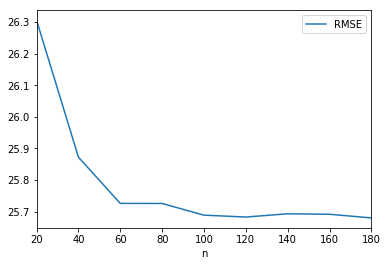

In [18]:
# Tryng another simple model - Random Forest - checkeding the hyperparameters using cross validation to avoid overfitting.
tscv = TimeSeriesSplit(n_splits=5)
RFR = [['n','RMSE']]
for n in range(20, 200, 20):
    clf = RandomForestRegressor(n_estimators=n, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    RFR.append([n, ((-scores)**0.5).mean()])

pd.DataFrame(data=RFR[1:], columns=RFR[0]).set_index('n').plot() # graph of the RMSE over the parameter.

> The RMSE is monotonusly decreases with n, but the slop is quite small in the end, so 180 is enough.

In [19]:
# Choosing the best hyperparameter from above for testing
model = RandomForestRegressor(n_estimators=180, random_state=42)
model.fit(X_train, y_train)
adding_results(model, 'Random Forest')

model: Random Forest, RMSE: 43.55


> There is an improvement in RMSE.

In [20]:
# Boost model can give us better results
model = CatBoostRegressor() #Catboost
model.fit(X_train, y_train,plot=True, silent=True)
adding_results(model, 'CatBoost')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

model: CatBoost, RMSE: 40.04


> Indeed there is an improvement.

In [21]:
#Another boost model - LGBMRegressor - checkeding the hyperparameters using cross validation
LGB = [['n_estim','leaves','RMSE']]
for n in range(50, 120, 20):  #running the model and saving the results in a table for comparing
    for l in range(20, 50, 10):
        model = lgb.LGBMRegressor(n_estimators=n, num_leaves=l, objective='regression')
        scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
        LGB.append([n, l, ((-scores)**0.5).mean()])

pd.DataFrame(data=LGB[1:], columns=LGB[0]).sort_values('RMSE') #We are looking for the lowest RMSE

,n_estim,leaves,RMSE
9,110,20,25.587504
6,90,20,25.594592
3,70,20,25.618560
7,90,30,25.627890
10,110,30,25.639459
4,70,30,25.645935
1,50,30,25.647660
2,50,40,25.684002
0,50,20,25.720330
8,90,40,25.728954


In [22]:
# Choosing the best hyperparameters from above for testing
model = lgb.LGBMRegressor(n_estimators=110, num_leaves=20, objective='regression') # Choosing the best from above for testing
model.fit(X_train, y_train)
adding_results(model, 'LGBM')

model: LGBM, RMSE: 41.48


> We tried a few models. Let's see who is the best.

## Conclusion

In [23]:
pd.DataFrame(data=results[1:], columns=results[0]).sort_values(by='RMSE') #The final results

,model,RMSE,R2
2,CatBoost,40.043791,0.533536
3,LGBM,41.479869,0.499479
1,Random Forest,43.545999,0.448375
0,Linear Regression,45.542447,0.396635


### Catboost gives us RMSE of 40, it is an improvement.